## IGO17483_IGO17721 IV Txp AT1401 3D KP Slc4a11-MCD Lenti-iRFP670-Gluc-Flex(tagBFP) IV vs KP Hopx-MACD BG/+ 
9/23/25 - Data generated from IV transplanted cells - Saline & DT treated; data submitted by CHP/EB; analyzed by JC 9/23/2025

Analyze global run on cellranger v8 data and create h5_ad files for further analysis - w/o introns

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import anndata
from joblib import dump, load

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
#Path("./figures/umap_density_Group_figures").mkdir(parents=True, exist_ok=True)
#Path("./figures/umapfigures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [4]:
results_file = 'write/GSE277777_IGO17483_IGO17721_Saline_DT.h5ad'  # the file that will store the analysis results

In [5]:
adata1 = anndata.read('../IGO17483/write/GSE277777_allmice-tumor-IGO17483-Vehicle.h5ad')
adata2 = anndata.read('../IGO17483/write/GSE277777_allmice-tumor-IGO17483-DT.h5ad')
adata3 = anndata.read('../IGO17721/write/GSE277777_allmice-tumor-IGO17721-Vehicle.h5ad')
adata4 = anndata.read('../IGO17721/write/GSE277777_allmice-tumor-IGO17721-DT.h5ad')

/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
adata1.obs.Classification.value_counts()

Classification
IV    4815
Name: count, dtype: int64

In [7]:
adata = adata1.concatenate(adata2,adata3,adata4, join='outer', batch_categories=['Slc_Saline', 'Slc_DT','Hopx_Saline','Hopx_DT'])
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_47391/741194739.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata1.concatenate(adata2,adata3,adata4, join='outer', batch_categories=['Slc_Saline', 'Slc_DT','Hopx_Saline','Hopx_DT'])


In [8]:
adata.obs.batch.value_counts()

batch
Hopx_DT        11332
Hopx_Saline    11318
Slc_DT         10411
Slc_Saline      4815
Name: count, dtype: int64

In [9]:
adata.obs['Allele'] = 'Slc4a11'

In [10]:
adata.obs['Allele'][adata.obs.batch.isin(['Hopx_DT','Hopx_Saline'])] = 'Hopx'

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_47391/3182453242.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['Allele'][adata.obs.batch.isin(['Hopx_DT','Hopx_Saline'])] = 'Hopx'
/var/folders/xc/wjwqs2j55dqgp2ghrn6

In [11]:
adata.obs.Allele.value_counts()

Allele
Hopx       22650
Slc4a11    15226
Name: count, dtype: int64

In [12]:
# Convert all columns in adata.raw.var to string, to make this h5ad compatible
for col in adata.var.columns:
    series = adata.var[col]
    if pd.api.types.is_categorical_dtype(series) or pd.api.types.is_object_dtype(series):
        adata.var[col] = series.astype(str)

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_47391/2496206387.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series) or pd.api.types.is_object_dtype(series):
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_47391/2496206387.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series) or pd.api.types.is_object_dtype(series):
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_47391/2496206387.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series) or pd.api.types.is_object_dtype(series):
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/

In [13]:
adata.write_h5ad('write/GSE277777_allmice-tumor-IGO17483_IGO17721_Vehicle_DT.h5ad', compression='gzip')

## Set highly variable genes

In [14]:
sc.pp.highly_variable_genes(adata, batch_key='batch')

extracting highly variable genes
    finished (0:00:17)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [15]:
adata.var.highly_variable = adata.var.highly_variable_intersection

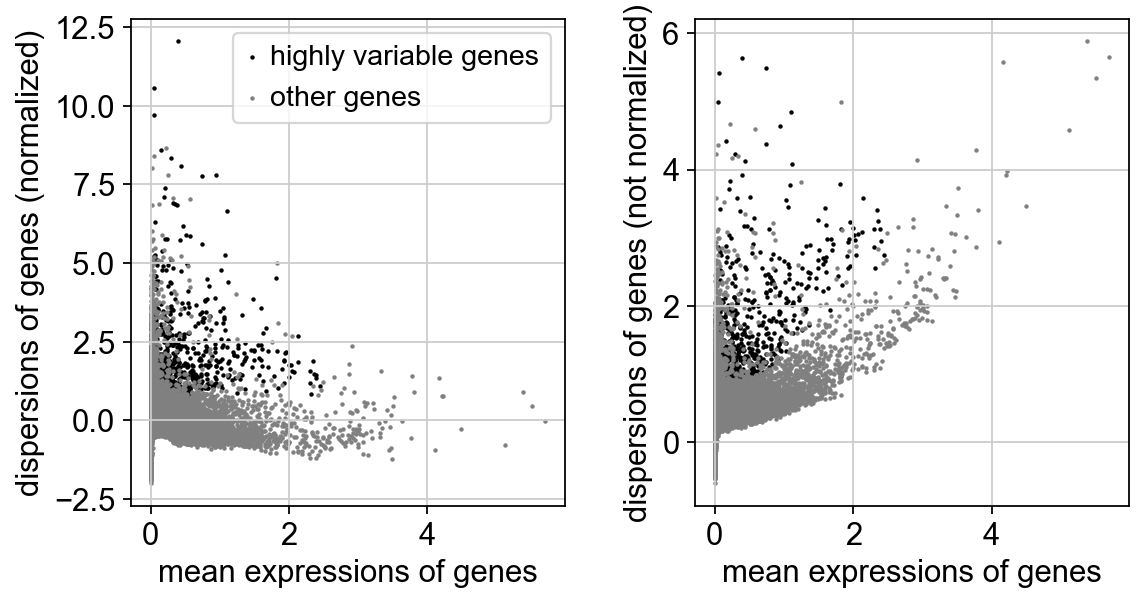

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tagBFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['iRFP670'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_47391/320926811.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_47391/3209268

In [18]:
adata.raw = adata

In [19]:
sc.pp.scale(adata, max_value=10)

/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [20]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:05)


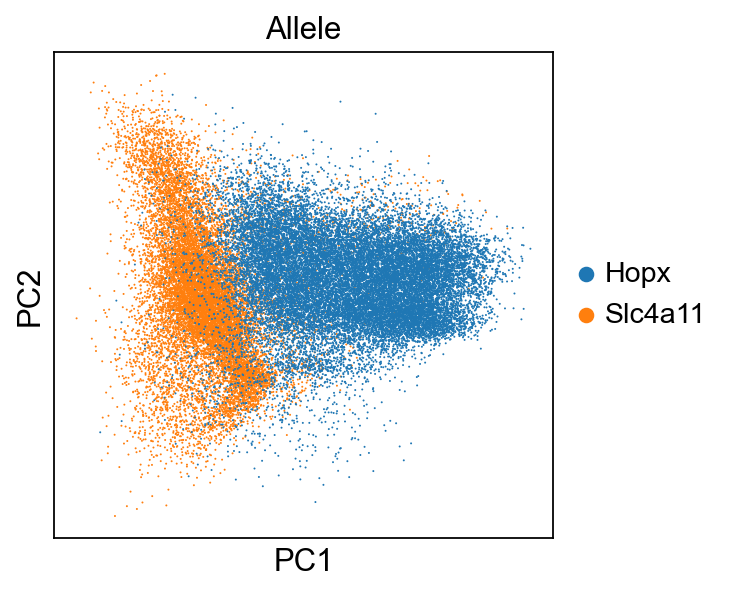

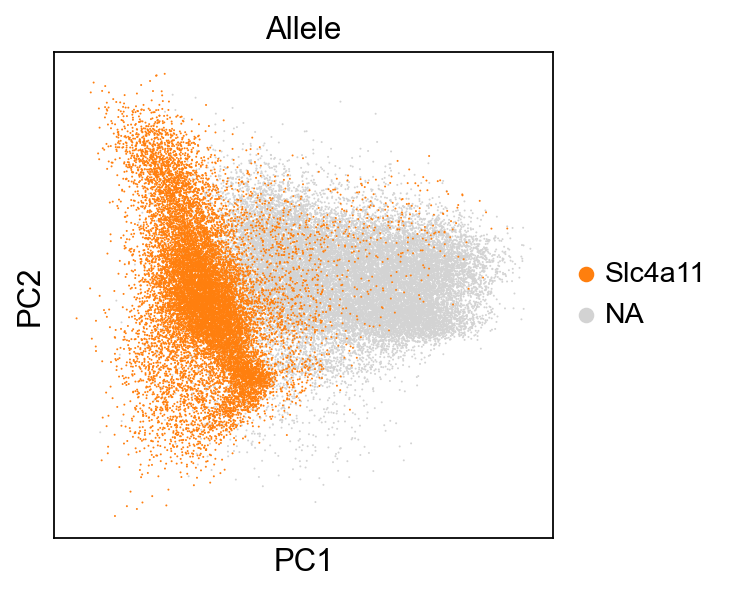

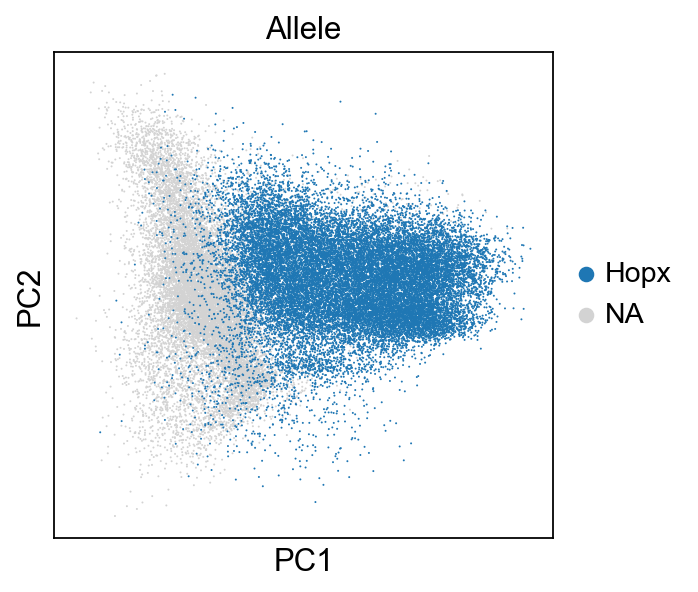

In [21]:
#sc.pl.pca(adata, color='leiden',dimensions=[(0,1)])
sc.pl.pca(adata, color='Allele',dimensions=[(0,1)])
sc.pl.pca(adata, color='Allele',dimensions=[(0,1)], groups=['Slc4a11'])
sc.pl.pca(adata, color='Allele',dimensions=[(0,1)], groups=['Hopx'])

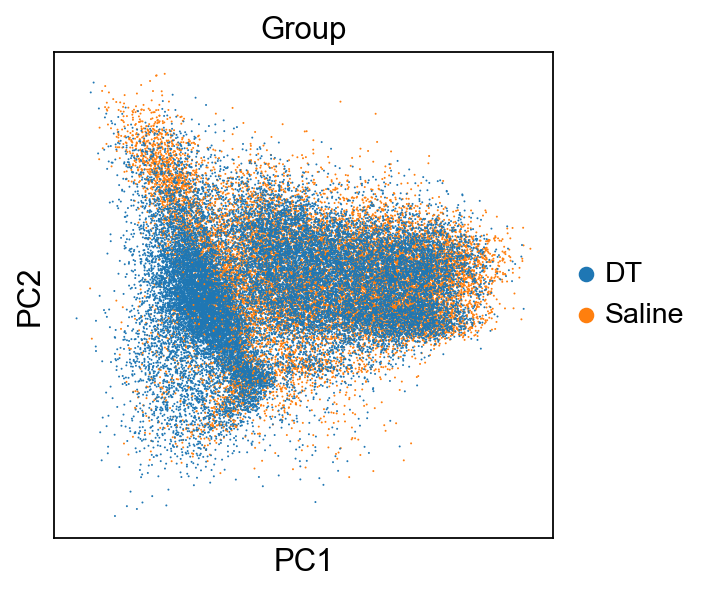

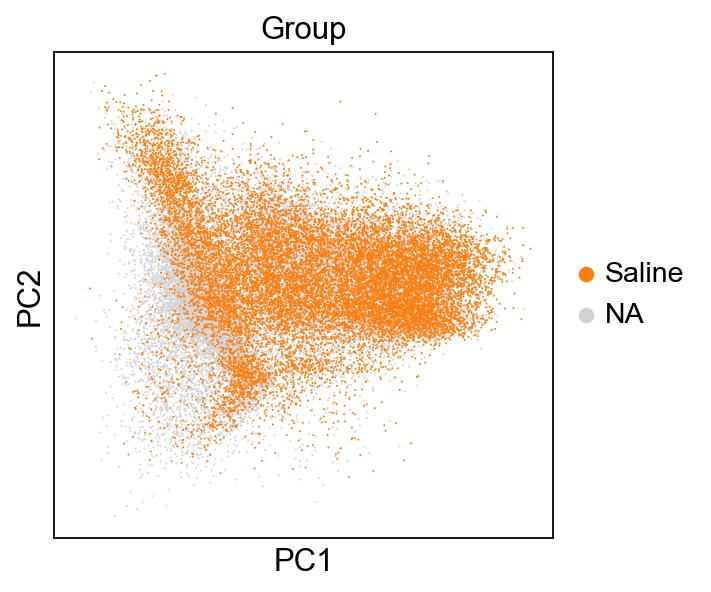

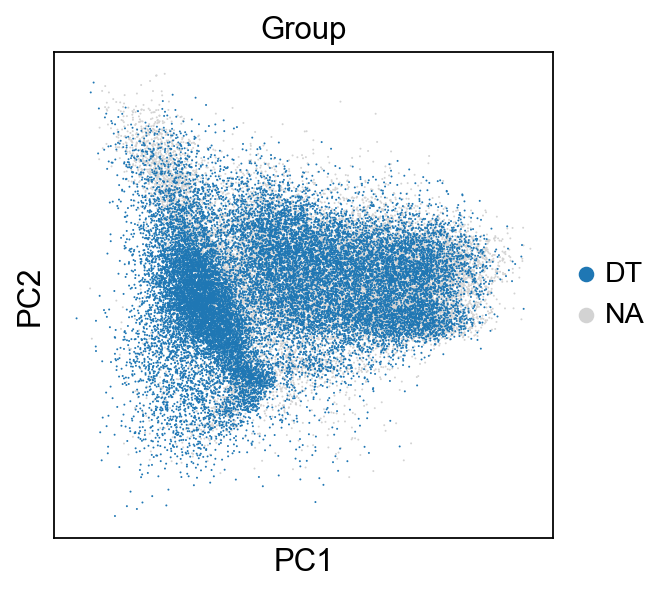

In [22]:
sc.pl.pca(adata, color='Group',dimensions=[(0,1)])
sc.pl.pca(adata, color='Group',dimensions=[(0,1)],groups=['Saline'])
sc.pl.pca(adata, color='Group',dimensions=[(0,1)],groups=['DT'])

# Calculate PV

In [23]:
#Phenotypic Volume
def calcPV(matrix):
    gene_cov = np.cov(matrix.T)
    mat = pd.DataFrame(gene_cov)
    eig_vals = np.linalg.eigvalsh(mat)
    return(sum(np.log2(eig_vals[eig_vals > 0])))

In [24]:
repeats = 1000

In [25]:
adata

AnnData object with n_obs × n_vars = 37876 × 27259
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log10GenesPerUMI', 'tagBFP_count', 'iRFP670_count', 'Cre_count', 'GLuc_count', 'scDblFinder_score', 'scDblFinder_class', 'Classification', 'Group', 'EGFP_count', 'Akaluc_count', 'iDTR_count', 'mScarlet_count', 'batch', 'Allele'
    var: 'gene_ids-Hopx_DT', 'feature_types-Hopx_DT', 'genome-Hopx_DT', 'n_cells-Hopx_DT', 'mt-Hopx_DT', 'n_cells_by_counts-Hopx_DT', 'mean_counts-Hopx_DT', 'pct_dropout_by_counts-Hopx_DT', 'total_counts-Hopx_DT', 'highly_variable-Hopx_DT', 'means-Hopx_DT', 'dispersions-Hopx_DT', 'dispersions_norm-Hopx_DT', 'gene_ids-Hopx_Saline', 'feature_types-Hopx_Saline', 'genome-Hopx_Saline', 'n_cells-Hopx_Saline', 'mt-Hopx_Saline', 'n_cells_by_counts-Hopx_Saline', 'mean_counts-Hopx_Saline', 'pct_dropout_by_counts-Hopx_Saline', 'total_counts-Hopx_Saline', 'highly_variable-Hopx_Saline', 'means-Hopx_Saline', 'dispersions-

In [26]:
adata.obs.Group.value_counts(sort=False)

Group
DT        21743
Saline    16133
Name: count, dtype: int64

In [27]:
adata.obs.batch.value_counts(sort=False)

batch
Slc_Saline      4815
Slc_DT         10411
Hopx_Saline    11318
Hopx_DT        11332
Name: count, dtype: int64

In [28]:
matrix = adata[adata.obs['batch'].isin(['Slc_Saline']),adata.var['highly_variable']].X.copy()
dist3 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist3.append(calcPV(matrix[sample_id]))

In [29]:
matrix = adata[adata.obs['batch'].isin(['Slc_DT']),adata.var['highly_variable']].X.copy()
dist4 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist4.append(calcPV(matrix[sample_id]))

In [30]:
matrix = adata[adata.obs['batch'].isin(['Hopx_Saline']),adata.var['highly_variable']].X.copy()
dist5 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist5.append(calcPV(matrix[sample_id]))

In [31]:
matrix = adata[adata.obs['batch'].isin(['Hopx_DT']),adata.var['highly_variable']].X.copy()
dist6 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist6.append(calcPV(matrix[sample_id]))

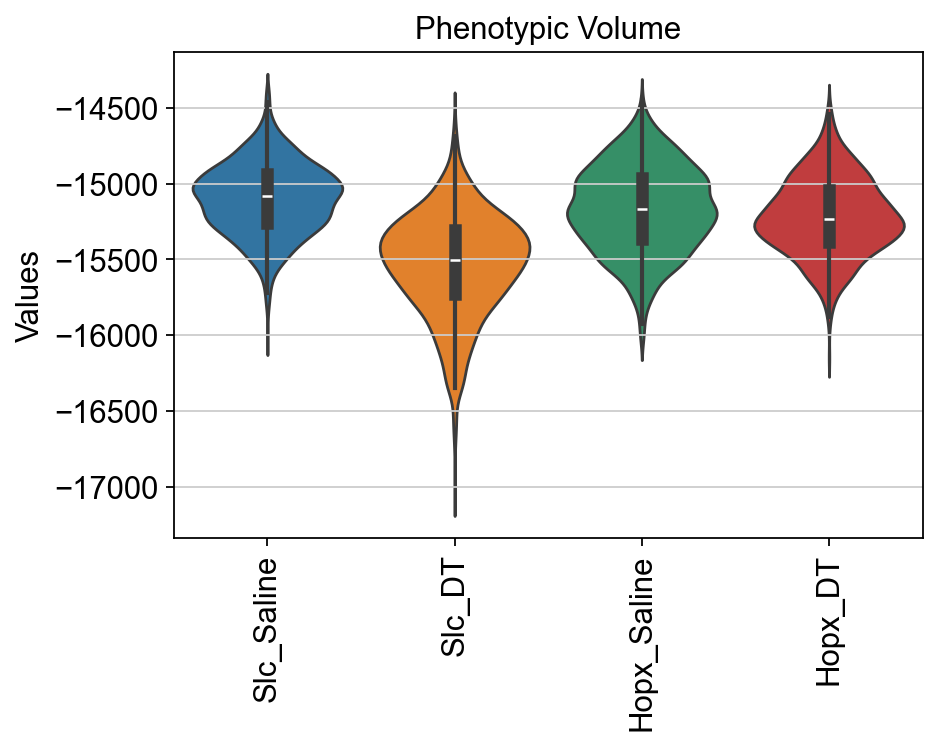

In [32]:
data = [dist3, dist4, dist5, dist6]
labels = ["Slc_Saline", "Slc_DT", "Hopx_Saline", "Hopx_DT"]

# Create violin plot using Seaborn
plt.figure(figsize=(6, 4))
sns.violinplot(data=data)
plt.xticks(ticks=[0, 1,2,3], labels=labels, rotation=90)
plt.ylabel("Values")
plt.title("Phenotypic Volume")
plt.show()

In [33]:
pd.DataFrame(np.column_stack((dist3, dist4,dist5, dist6)),columns=["Slc_Saline", "Slc_DT", "Hopx_Saline", "Hopx_DT"]).to_excel('Ext_Data_Fig_9n_PV_traced.xlsx')